In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
#
# random time series
#
date = pd.date_range(start='2015-01', end='2015-05', freq='D')
price = np.random.randint(-100, 100, size=len(date))
df = pd.DataFrame(price, index=date, columns=['close'])
df = df.cumsum()

In [4]:
#
# Real ticker data
#
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

In [5]:
strategyname = 'strategy_180113'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame()
df['close'] = d.exo

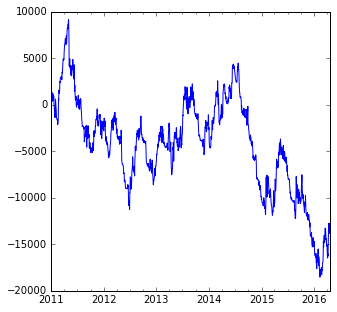

In [6]:
figsize(5,5)
d.exo.plot()

In [7]:
info

{'legs': 3,
 'margin': 4510,
 'name': 'CallSpread',
 'pcf': array([0, 0, 2], dtype=uint8),
 'pcfqty': array([ 1, -1,  0], dtype=int16),
 'tickincrement': 0.01,
 'tickvalue': 10,
 'underlying': 'CLE'}

## Renko calculation

## High/Low of renko bricks is only needed for visual representation

In [8]:
box_size = 200

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

# Simple renko algorihtm


# 
for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start
        
        # First of all we need to set box size. 
        # Then calculate price movement. 
        # If price movement is more or equal than box size - renko bar(or bars) will be added
        
        if np.abs(price_move) >= box_size:
            
            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much renko bars will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_index = df.close.index[i]

            for b in range(int(box_quantity)):
            # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
            # So renko bar 1 will have next parameters - 
            # 1)index 2015-01-01
            # 2)open = 100
            # 3)close = 110(box_start + box_size)
            # 4)type = up
            
            # Next renko bar will have next parameters -
            # 1)index 2015-01-01
            # 2)open = 110(previous renko bar close)
            # 3)close = 120(open + box_size)
            # 4)type = up
            
            # And so on..
            
            # After all we adding renko bars dict to list and convert it to DF
            
                if price_move > 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:
                        d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                            'type': 'up'}
                        
                        box_end = d['close']
                        temp_l.append(d)

                if price_move < 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:           
                        d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                             'type': 'down'}
                        
                        box_end = d['close']
                        temp_l.append(d)
                        
            box_start = df.close[i]
            
renko_df = pd.DataFrame(temp_l)

del temp_l

high_l = []
low_l = []
for i in range(len(renko_df)):
    if renko_df.close[i] > renko_df.open[i]:
        high_l.append(renko_df.close[i])
        low_l.append(renko_df.open[i])
        
    if renko_df.close[i] < renko_df.open[i]:
        high_l.append(renko_df.open[i])
        low_l.append(renko_df.close[i])
        
renko_df['low'] = low_l
renko_df['high'] = high_l

del low_l
del high_l

## Defining peaks and falls and their prices

In [9]:
# Peaks
renko_peak = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') 
          & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'up'))

renko_df['peak'] = renko_peak

# Adding underlying_pick_price column
ul_peak_price = df.close[df.close.index.isin(renko_df[renko_df.peak.shift(-2) == True].date)]
ul_peak_price.name = 'underlying_peak_price'

renko_df = renko_df.join(ul_peak_price, on=['date'])
renko_df.underlying_peak_price = renko_df.underlying_peak_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.peak == False, 'underlying_peak_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_peak_price'] = renko_df.close[renko_df.peak.shift(-2) == True]
renko_df.renko_peak_price = renko_df.renko_peak_price.shift(2) #This needed for avoiding future reference problem

In [10]:
# Falls
renko_fall = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') 
          & (renko_df.type.shift(2) == 'down') & (renko_df.type.shift(3) == 'down'))

renko_df['fall'] = renko_fall

# Adding underlying_fall_price column 
ul_fall_price = df.close[df.close.index.isin(renko_df[renko_df.fall.shift(-2) == True].date)]
ul_fall_price.name = 'underlying_fall_price'

renko_df = renko_df.join(ul_fall_price, on=['date'])
renko_df.underlying_fall_price = renko_df.underlying_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.fall == False, 'underlying_fall_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_fall_price'] = renko_df.close[renko_df.fall.shift(-2) == True]
renko_df.renko_fall_price = renko_df.renko_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df = renko_df.fillna(method='ffill')

## Flat and trend patterns

In [11]:
renko_flat = (((renko_df.type == 'up') & (renko_df.type.shift(1) == 'down') 
                & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'down')) | 
              ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down') 
             & (renko_df.type.shift(3) == 'up')))

renko_df['flat'] = renko_flat

renko_trend_up = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'up'))
renko_trend_down = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'down'))

renko_df['trend_up'] = renko_trend_up
renko_df['trend_down'] = renko_trend_down

## Small double top/bottom pattern

In [12]:
renko_small_double_top = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'up')
                         & (renko_df.type.shift(3) == 'down') & (renko_df.type.shift(4) == 'up') & (renko_df.type.shift(5) == 'up'))

renko_df['small_double_top'] = renko_small_double_top

renko_small_double_bottom = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down')
                         & (renko_df.type.shift(3) == 'up') & (renko_df.type.shift(4) == 'down') & (renko_df.type.shift(5) == 'down'))

renko_df['small_double_bottom'] = renko_small_double_bottom

## Trend correction pattern( no.7 in renko patterns.pdf)

In [13]:
renko_up_trend_correction = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down')
                            & (renko_df.type.shift(3) == 'up') & (renko_df.type.shift(4) == 'up'))

renko_df['up_trend_correction'] = renko_up_trend_correction

renko_down_trend_correction = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'up')
                            & (renko_df.type.shift(3) == 'down') & (renko_df.type.shift(4) == 'down'))

renko_df['down_trend_correction'] = renko_down_trend_correction

## Peak/fall prices combinations

### Defining peak/fall price direction relative to previous peak/fall price

In [14]:
renko_peak_df = renko_df[renko_df.peak == True]

renko_peak_price_move = np.array([None] * len(renko_peak_df.type))
#renko_peak_price_move = np.empty_like(renko_peak_df.type) # This code crashes the python...

for i in range(len(renko_peak_df)):
    if i > 0:
        if renko_peak_df.renko_peak_price.values[i] > renko_peak_df.renko_peak_price.values[i-1]: 
            renko_peak_price_move[i] = 'up'
            
        elif renko_peak_df.renko_peak_price.values[i] < renko_peak_df.renko_peak_price.values[i-1]:
            renko_peak_price_move[i] = 'down'
            
        elif renko_peak_df.renko_peak_price.values[i-1] == renko_peak_df.renko_peak_price.values[i]:
            renko_peak_price_move[i] = 'same'

renko_df = renko_df.join(pd.Series(renko_peak_price_move, index=renko_peak_df.index, name='renko_peak_price_move').replace([None],np.NaN))

In [15]:
renko_fall_df = renko_df[renko_df.fall == True]

renko_fall_price_move = np.array([None] * len(renko_fall_df.type))

for i in range(len(renko_fall_df)):
    if i > 0:
        if renko_fall_df.renko_fall_price.values[i] > renko_fall_df.renko_fall_price.values[i-1]: 
            renko_fall_price_move[i] = 'up'
            
        elif renko_fall_df.renko_fall_price.values[i] < renko_fall_df.renko_fall_price.values[i-1]:
            renko_fall_price_move[i] = 'down'
            
        elif renko_fall_df.renko_fall_price.values[i-1] == renko_fall_df.renko_fall_price.values[i]:
            renko_fall_price_move[i] = 'same'

renko_df = renko_df.join(pd.Series(renko_fall_price_move, index=renko_fall_df.index, name='renko_fall_price_move').replace([None],np.NaN))

## Patterns
#### Peak

In [16]:
renko_df.renko_peak_price_move.dropna()

16      down
41      down
79        up
98        up
104       up
116       up
141     down
152     down
166       up
182     down
199     down
208     down
220     same
229     down
240     down
265     down
286     down
296     same
311     down
321     same
333       up
349       up
357     down
382       up
397     down
407       up
412     down
424     down
438     down
454       up
        ... 
1640    same
1654      up
1667      up
1676    down
1687      up
1697    down
1709    down
1717    down
1760    down
1769    down
1780    down
1788    same
1802    same
1810    down
1833      up
1846    down
1864      up
1881    down
1888    down
1905    down
1910    down
1921    down
1934    down
1942      up
1954    down
1970    down
1989      up
1997      up
2006      up
2037      up
Name: renko_peak_price_move, dtype: object

In [17]:
renko_2_peaks_down = ((renko_df.renko_peak_price_move.dropna() == 'down') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'down'))
renko_2_peaks_down.name = 'two_descending_peaks'
renko_df = renko_df.join(renko_2_peaks_down)


renko_3_peaks_down = ((renko_df.renko_peak_price_move.dropna() == 'down') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'down')
              & (renko_df.renko_peak_price_move.dropna().shift(2) == 'down'))

renko_3_peaks_down.name = 'three_descending_peaks'
renko_df = renko_df.join(renko_3_peaks_down)


renko_2_peaks_down = ((renko_df.renko_peak_price_move.dropna() == 'up') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'up'))
renko_2_peaks_down.name = 'two_ascending_peaks'
renko_df = renko_df.join(renko_2_peaks_down)


renko_3_peaks_up = ((renko_df.renko_peak_price_move.dropna() == 'up') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'up')
                   & (renko_df.renko_peak_price_move.dropna().shift(2) == 'up'))

renko_3_peaks_up.name = 'three_ascending_peaks'
renko_df = renko_df.join(renko_3_peaks_up)


renko_2_peaks_same = ((renko_df.renko_peak_price_move.dropna() == 'same') & (renko_df.renko_peak_price_move.dropna().shift(1) == 'same'))
renko_2_peaks_same.name = 'two_same_peaks'
renko_df = renko_df.join(renko_2_peaks_same)

#### Fall

In [18]:
renko_2_falls_down = ((renko_df.renko_fall_price_move.dropna() == 'down') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'down'))
renko_2_falls_down.name = 'two_descending_falls'
renko_df = renko_df.join(renko_2_falls_down)


renko_3_falls_down = ((renko_df.renko_fall_price_move.dropna() == 'down') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'down')
              & (renko_df.renko_fall_price_move.dropna().shift(2) == 'down'))

renko_3_falls_down.name = 'three_descending_falls'
renko_df = renko_df.join(renko_3_falls_down)


renko_2_falls_down = ((renko_df.renko_fall_price_move.dropna() == 'up') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'up'))
renko_2_falls_down.name = 'two_ascending_falls'
renko_df = renko_df.join(renko_2_falls_down)


renko_3_falls_up = ((renko_df.renko_fall_price_move.dropna() == 'up') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'up')
                   & (renko_df.renko_fall_price_move.dropna().shift(2) == 'up'))

renko_3_falls_up.name = 'three_ascending_falls'
renko_df = renko_df.join(renko_3_falls_up)


renko_2_falls_same = ((renko_df.renko_fall_price_move.dropna() == 'same') & (renko_df.renko_fall_price_move.dropna().shift(1) == 'same'))
renko_2_falls_same.name = 'two_same_falls'
renko_df = renko_df.join(renko_2_falls_same)

In [19]:
renko_df

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,...,two_descending_peaks,three_descending_peaks,two_ascending_peaks,three_ascending_peaks,two_same_peaks,two_descending_falls,three_descending_falls,two_ascending_falls,three_ascending_falls,two_same_falls
0,1900.0,2011-01-04,2100.0,down,1900.0,2100.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1700.0,2011-01-04,1900.0,down,1700.0,1900.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1500.0,2011-01-04,1700.0,down,1500.0,1700.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1300.0,2011-01-04,1500.0,down,1300.0,1500.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1100.0,2011-01-04,1300.0,down,1100.0,1300.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,900.0,2011-01-04,1100.0,down,900.0,1100.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1100.0,2011-01-05,900.0,up,900.0,1100.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1300.0,2011-01-05,1100.0,up,1100.0,1300.0,False,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1100.0,2011-01-06,1300.0,down,1100.0,1300.0,False,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,900.0,2011-01-06,1100.0,down,900.0,1100.0,True,1330.0,1300.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
renko_df.renko_fall_price_move.dropna()

13      down
32      down
52      down
81        up
100       up
108     same
138     down
148     down
156     same
175     down
196     down
206     down
213     down
226     down
236     down
258     down
276     down
291       up
309     down
325     down
335       up
355       up
359     same
375     down
390     down
401       up
410       up
422     down
440     down
457       up
        ... 
1637      up
1642      up
1660      up
1673      up
1681    down
1693    same
1701    same
1707    same
1714    down
1739    down
1767      up
1776    down
1784    same
1795    down
1807      up
1817    down
1844      up
1853    down
1886    down
1901    down
1908      up
1919    down
1928    down
1937      up
1950    down
1973    down
1992      up
2000      up
2019    down
2041      up
Name: renko_fall_price_move, dtype: object

## Consecutive up/down brick count

In [21]:
up_count = np.zeros_like(renko_df.index)
up_counter = 0

down_count = np.zeros_like(renko_df.index)
down_counter = 0


for i in range(len(renko_df.index)):
    if i > 0:
    
        if (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            up_counter = 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'up'):
            up_counter += 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            up_counter = 0
            up_count[i] = up_counter
            
        else:
            up_counter = 0
            up_count[i] = up_counter
        
        
        
        if (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            down_counter = 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'down'):
            down_counter += 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            down_counter = 0
            down_count[i] = down_counter
            
        else:
            down_counter = 0
            down_count[i] = down_counter
            
renko_df['up_count'] = up_count
renko_df['down_count'] = down_count

In [22]:
renko_df[renko_df.peak == True]

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,...,two_ascending_peaks,three_ascending_peaks,two_same_peaks,two_descending_falls,three_descending_falls,two_ascending_falls,three_ascending_falls,two_same_falls,up_count,down_count
9,900.0,2011-01-06,1100.0,down,900.0,1100.0,True,1330.0,1300.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
16,700.0,2011-01-13,900.0,down,700.0,900.0,True,1200.0,1100.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
41,100.0,2011-02-03,300.0,down,100.0,300.0,True,620.0,500.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
79,2500.0,2011-03-15,2700.0,down,2500.0,2700.0,True,3090.0,2900.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
98,5500.0,2011-04-12,5700.0,down,5500.0,5700.0,True,6950.0,5900.0,False,...,True,False,False,NaN,NaN,NaN,NaN,NaN,0,2
104,5900.0,2011-04-18,6100.0,down,5900.0,6100.0,True,7430.0,6300.0,False,...,True,True,False,NaN,NaN,NaN,NaN,NaN,0,2
116,6700.0,2011-05-03,6900.0,down,6700.0,6900.0,True,8980.0,7100.0,False,...,True,True,False,NaN,NaN,NaN,NaN,NaN,0,2
141,2900.0,2011-05-11,3100.0,down,2900.0,3100.0,True,4930.0,3300.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
152,2300.0,2011-05-19,2500.0,down,2300.0,2500.0,True,4140.0,2700.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
166,3100.0,2011-06-01,3300.0,down,3100.0,3300.0,True,4880.0,3500.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2


In [23]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
from datetime import datetime
import plotly.graph_objs as go

py.sign_in('dmveden', 'rzbs7xw8ft')
#py.sign_in('tmqr', '8rctfyu197')

fig = FF.create_candlestick(renko_df.open, renko_df.high, renko_df.low, renko_df.close, dates=renko_df.index)
py.iplot(fig)

The draw time for this plot will be slow for all clients.


C:\Users\user\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:1443: UserWarning:

Estimated Draw Time Too Long



In [85]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

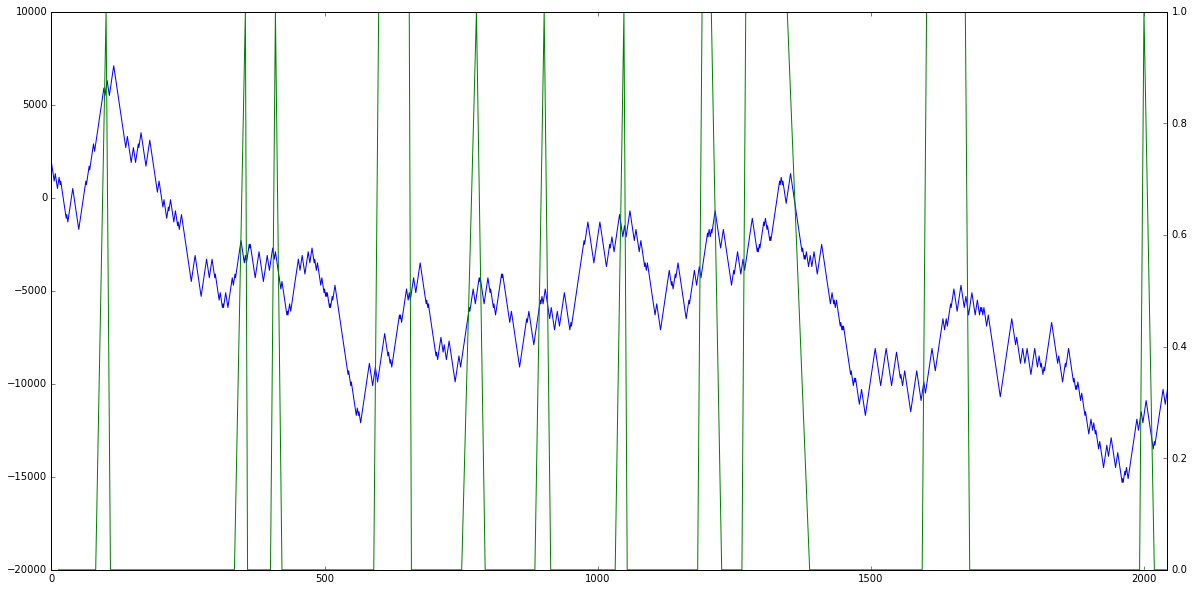

In [34]:
figsize(20,10)
renko_df.close[:].plot()
#renko_df.low[:].plot()

#renko_df.peak.plot(secondary_y=True)

renko_df.two_ascending_falls.dropna().plot(secondary_y=True)

#renko_df.small_double_bottom.plot(secondary_y=True)
#renko_df.small_double_top.plot(secondary_y=True)

In [35]:
renko_df[renko_df.two_descending_peaks == True]

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,...,two_ascending_peaks,three_ascending_peaks,two_same_peaks,two_descending_falls,three_descending_falls,two_ascending_falls,three_ascending_falls,two_same_falls,up_count,down_count
41,100.0,2011-02-03,300.0,down,100.0,300.0,True,620.0,500.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
152,2300.0,2011-05-19,2500.0,down,2300.0,2500.0,True,4140.0,2700.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
199,500.0,2011-06-15,700.0,down,500.0,700.0,True,2130.0,900.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
208,-500.0,2011-06-23,-300.0,down,-500.0,-300.0,True,910.0,-100.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
240,-1300.0,2011-07-27,-1100.0,down,-1300.0,-1100.0,True,540.0,-900.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
265,-3500.0,2011-09-02,-3300.0,down,-3500.0,-3300.0,True,-2290.0,-3100.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
286,-3700.0,2011-09-09,-3500.0,down,-3700.0,-3500.0,True,-2380.0,-3300.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
424,-4900.0,2012-01-20,-4700.0,down,-4900.0,-4700.0,True,-3440.0,-4500.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
438,-6100.0,2012-02-10,-5900.0,down,-6100.0,-5900.0,True,-4980.0,-5700.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2
497,-4700.0,2012-04-03,-4500.0,down,-4700.0,-4500.0,True,-2580.0,-4300.0,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,0,2


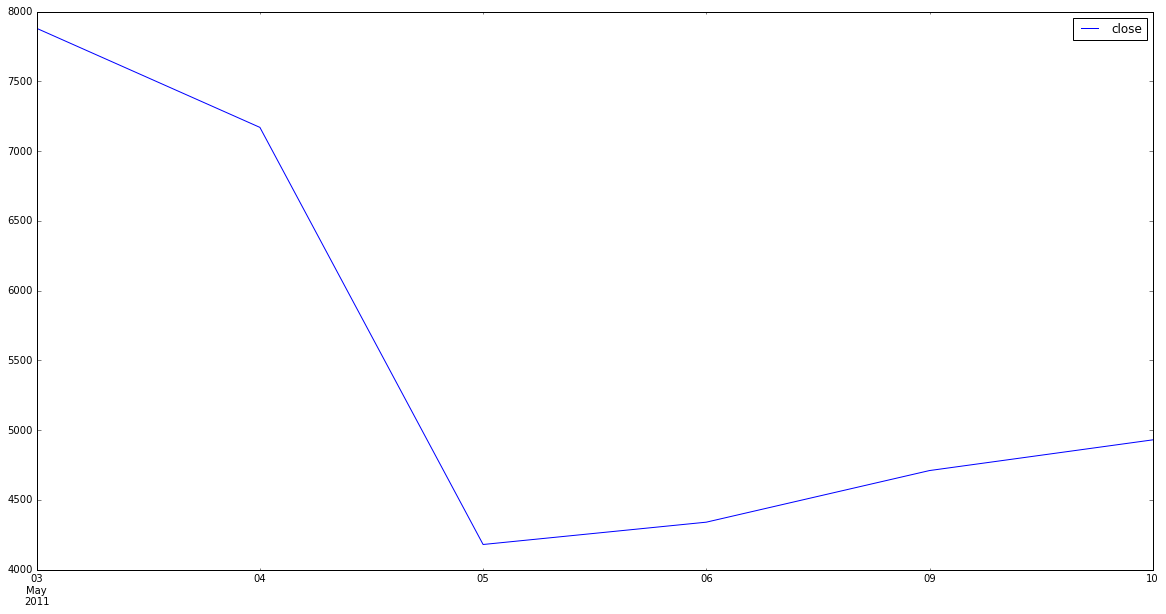

In [116]:
df.ix['2011-05-03':'2011-05-10'].plot()